# My Example Solution for DeepAR


- This project aims to predict sales for various product families sold at Favorita stores in Ecuador. By leveraging historical sales data and additional contextual information, we develop a predictive model to forecast future sales accurately. The solution involves analyzing time-series data, incorporating external factors such as promotions, holidays, and economic indicators to enhance prediction accuracy.


### Imporinting Libraries


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from visualising import *


import lightning.pytorch as pl

import torch

from lightning.pytorch.callbacks import EarlyStopping
import pytorch_forecasting as pf
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss

In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! PyTorch can use your GPU.")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}") # Or whatever device index
else:
    print("CUDA is NOT available. PyTorch cannot use your GPU.")
    print("Please check your CUDA installation, GPU drivers, and PyTorch version.")

CUDA is available! PyTorch can use your GPU.
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce GTX 1650 with Max-Q Design


### Data Loading


In [3]:
df_train = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)
df_oil = pd.read_csv('data/oil.csv', index_col=0, parse_dates=True)
df_stores = pd.read_csv('data/stores.csv', index_col=0, parse_dates=True)
df_test = pd.read_csv('data/test.csv', index_col=0, parse_dates=True)
df_transactions = pd.read_csv('data/transactions.csv', index_col=0, parse_dates=True)
df_holiday = pd.read_csv('data/holidays_events.csv', index_col=0, parse_dates=True)

/tmp/ipykernel_28757/917830957.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_28757/917830957.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_stores = pd.read_csv('data/stores.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_28757/917830957.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test = pd.read_csv('data/test.csv', index_col=0, parse_dates=True)


### Data Preprocessing


In [4]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.set_index('date', inplace=True)

In [5]:
df_train

store_nbr                      family     sales  onpromotion
date                                                                    
2013-01-01          1                  AUTOMOTIVE     0.000            0
2013-01-01          1                   BABY CARE     0.000            0
2013-01-01          1                      BEAUTY     0.000            0
2013-01-01          1                   BEVERAGES     0.000            0
2013-01-01          1                       BOOKS     0.000            0
...               ...                         ...       ...          ...
2017-08-15          9                     POULTRY   438.133            0
2017-08-15          9              PREPARED FOODS   154.553            1
2017-08-15          9                     PRODUCE  2419.729          148
2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000            8
2017-08-15          9                     SEAFOOD    16.000            0

[3000888 rows x 4 columns]

In [6]:
df_train.describe()

store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06
mean   2.750000e+01  3.577757e+02  2.602770e+00
std    1.558579e+01  1.101998e+03  1.221888e+01
min    1.000000e+00  0.000000e+00  0.000000e+00
25%    1.400000e+01  0.000000e+00  0.000000e+00
50%    2.750000e+01  1.100000e+01  0.000000e+00
75%    4.100000e+01  1.958473e+02  0.000000e+00
max    5.400000e+01  1.247170e+05  7.410000e+02

In [7]:
df_train.shape

(3000888, 4)

In [8]:
df_stores.head()

city                           state type  cluster
store_nbr                                                             
1                  Quito                       Pichincha    D       13
2                  Quito                       Pichincha    D       13
3                  Quito                       Pichincha    D        8
4                  Quito                       Pichincha    D        9
5          Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [9]:
df_stores.shape

(54, 4)

### Data Merging


In [10]:
df_combined = df_train.merge(df_stores,how='left', left_on='store_nbr', right_index=True)

In [11]:
df_combined.shape

(3000888, 8)

In [12]:
df_combined.head()

store_nbr      family  sales  onpromotion   city      state type  \
date                                                                           
2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha    D   
2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha    D   
2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha    D   
2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha    D   
2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha    D   

            cluster  
date                 
2013-01-01       13  
2013-01-01       13  
2013-01-01       13  
2013-01-01       13  
2013-01-01       13

In [13]:
df_combined.describe()

store_nbr         sales   onpromotion       cluster
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   2.750000e+01  3.577757e+02  2.602770e+00  8.481481e+00
std    1.558579e+01  1.101998e+03  1.221888e+01  4.649735e+00
min    1.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
25%    1.400000e+01  0.000000e+00  0.000000e+00  4.000000e+00
50%    2.750000e+01  1.100000e+01  0.000000e+00  8.500000e+00
75%    4.100000e+01  1.958473e+02  0.000000e+00  1.300000e+01
max    5.400000e+01  1.247170e+05  7.410000e+02  1.700000e+01

In [14]:
df_oil

dcoilwtico
date                  
2013-01-01         NaN
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-07       93.20
...                ...
2017-08-25       47.65
2017-08-28       46.40
2017-08-29       46.46
2017-08-30       45.96
2017-08-31       47.26

[1218 rows x 1 columns]

In [15]:
df_oil.index = pd.to_datetime(df_oil.index)


In [16]:
df_combined_oil = df_combined.merge(df_oil, how='left', left_index=True, right_index=True)

In [17]:
df_combined_oil.head()

store_nbr      family  sales  onpromotion   city      state type  \
date                                                                           
2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha    D   
2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha    D   
2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha    D   
2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha    D   
2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha    D   

            cluster  dcoilwtico  
date                             
2013-01-01       13         NaN  
2013-01-01       13         NaN  
2013-01-01       13         NaN  
2013-01-01       13         NaN  
2013-01-01       13         NaN

In [18]:
merged_df = df_combined_oil.merge(
    df_transactions,
    how='left',
    left_on=['date', 'store_nbr'],
    right_on=['date', 'store_nbr']
)

In [19]:
merged_df

store_nbr                      family     sales  onpromotion  \
date                                                                       
2013-01-01          1                  AUTOMOTIVE     0.000            0   
2013-01-01          1                   BABY CARE     0.000            0   
2013-01-01          1                      BEAUTY     0.000            0   
2013-01-01          1                   BEVERAGES     0.000            0   
2013-01-01          1                       BOOKS     0.000            0   
...               ...                         ...       ...          ...   
2017-08-15          9                     POULTRY   438.133            0   
2017-08-15          9              PREPARED FOODS   154.553            1   
2017-08-15          9                     PRODUCE  2419.729          148   
2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000            8   
2017-08-15          9                     SEAFOOD    16.000            0   

             city      state type  cluster  dcoilwtico  transactions  
date                                                                  
2013-01-01  Quito  Pichincha    D       13         NaN           NaN  
2013-01-01  Quito  Pichincha    D       13         NaN           NaN  
2013-01-01  Quito  Pichincha    D       13         NaN           NaN  
2013-01-01  Quito  Pichincha    D       13         NaN           NaN  
2013-01-01  Quito  Pichincha    D       13         NaN           NaN  
...           ...        ...  ...      ...         ...           ...  
2017-08-15  Quito  Pichincha    B        6       47.57        2155.0  
2017-08-15  Quito  Pichincha    B        6       47.57        2155.0  
2017-08-15  Quito  Pichincha    B        6       47.57        2155.0  
2017-08-15  Quito  Pichincha    B        6       47.57        2155.0  
2017-08-15  Quito  Pichincha    B        6       47.57        2155.0  

[3000888 rows x 10 columns]

#### //// For this moment merged

#### train-oil-transaction-stores ---> -holiday


In [20]:
df_holiday

type    locale locale_name                    description  \
date                                                                          
2012-03-02     Holiday     Local       Manta             Fundacion de Manta   
2012-04-01     Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2012-04-12     Holiday     Local      Cuenca            Fundacion de Cuenca   
2012-04-14     Holiday     Local    Libertad      Cantonizacion de Libertad   
2012-04-21     Holiday     Local    Riobamba      Cantonizacion de Riobamba   
...                ...       ...         ...                            ...   
2017-12-22  Additional  National     Ecuador                      Navidad-3   
2017-12-23  Additional  National     Ecuador                      Navidad-2   
2017-12-24  Additional  National     Ecuador                      Navidad-1   
2017-12-25     Holiday  National     Ecuador                        Navidad   
2017-12-26  Additional  National     Ecuador                      Navidad+1   

            transferred  
date                     
2012-03-02        False  
2012-04-01        False  
2012-04-12        False  
2012-04-14        False  
2012-04-21        False  
...                 ...  
2017-12-22        False  
2017-12-23        False  
2017-12-24        False  
2017-12-25        False  
2017-12-26        False  

[350 rows x 5 columns]

In [21]:
merged_df_final = merged_df.merge(df_holiday, how='left', left_index=True, right_index=True)

In [22]:
merged_df_final

store_nbr                      family     sales  onpromotion  \
date                                                                       
2013-01-01          1                  AUTOMOTIVE     0.000            0   
2013-01-01          1                   BABY CARE     0.000            0   
2013-01-01          1                      BEAUTY     0.000            0   
2013-01-01          1                   BEVERAGES     0.000            0   
2013-01-01          1                       BOOKS     0.000            0   
...               ...                         ...       ...          ...   
2017-08-15          9                     POULTRY   438.133            0   
2017-08-15          9              PREPARED FOODS   154.553            1   
2017-08-15          9                     PRODUCE  2419.729          148   
2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000            8   
2017-08-15          9                     SEAFOOD    16.000            0   

             city      state type_x  cluster  dcoilwtico  transactions  \
date                                                                     
2013-01-01  Quito  Pichincha      D       13         NaN           NaN   
2013-01-01  Quito  Pichincha      D       13         NaN           NaN   
2013-01-01  Quito  Pichincha      D       13         NaN           NaN   
2013-01-01  Quito  Pichincha      D       13         NaN           NaN   
2013-01-01  Quito  Pichincha      D       13         NaN           NaN   
...           ...        ...    ...      ...         ...           ...   
2017-08-15  Quito  Pichincha      B        6       47.57        2155.0   
2017-08-15  Quito  Pichincha      B        6       47.57        2155.0   
2017-08-15  Quito  Pichincha      B        6       47.57        2155.0   
2017-08-15  Quito  Pichincha      B        6       47.57        2155.0   
2017-08-15  Quito  Pichincha      B        6       47.57        2155.0   

             type_y    locale locale_name            description transferred  
date                                                                          
2013-01-01  Holiday  National     Ecuador     Primer dia del ano       False  
2013-01-01  Holiday  National     Ecuador     Primer dia del ano       False  
2013-01-01  Holiday  National     Ecuador     Primer dia del ano       False  
2013-01-01  Holiday  National     Ecuador     Primer dia del ano       False  
2013-01-01  Holiday  National     Ecuador     Primer dia del ano       False  
...             ...       ...         ...                    ...         ...  
2017-08-15  Holiday     Local    Riobamba  Fundacion de Riobamba       False  
2017-08-15  Holiday     Local    Riobamba  Fundacion de Riobamba       False  
2017-08-15  Holiday     Local    Riobamba  Fundacion de Riobamba       False  
2017-08-15  Holiday     Local    Riobamba  Fundacion de Riobamba       False  
2017-08-15  Holiday     Local    Riobamba  Fundacion de Riobamba       False  

[3054348 rows x 15 columns]

In [23]:
merged_df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Data columns (total 15 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_nbr     int64  
 1   family        object 
 2   sales         float64
 3   onpromotion   int64  
 4   city          object 
 5   state         object 
 6   type_x        object 
 7   cluster       int64  
 8   dcoilwtico    float64
 9   transactions  float64
 10  type_y        object 
 11  locale        object 
 12  locale_name   object 
 13  description   object 
 14  transferred   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 372.8+ MB


In [24]:
merged_df_final.isna().sum()
merged_df_final.fillna(0, inplace=True)

In [25]:
categorical = merged_df_final.select_dtypes(include=['object']).columns
for col in categorical:
    val = merged_df_final[col].nunique()
    print(f"Column {col} has {val} unique values.")

Column family has 33 unique values.
Column city has 22 unique values.
Column state has 16 unique values.
Column type_x has 5 unique values.
Column type_y has 7 unique values.
Column locale has 4 unique values.
Column locale_name has 25 unique values.
Column description has 102 unique values.
Column transferred has 2 unique values.


In [26]:
merged_df_final[categorical]

family   city      state type_x   type_y  \
date                                                                       
2013-01-01                  AUTOMOTIVE  Quito  Pichincha      D  Holiday   
2013-01-01                   BABY CARE  Quito  Pichincha      D  Holiday   
2013-01-01                      BEAUTY  Quito  Pichincha      D  Holiday   
2013-01-01                   BEVERAGES  Quito  Pichincha      D  Holiday   
2013-01-01                       BOOKS  Quito  Pichincha      D  Holiday   
...                                ...    ...        ...    ...      ...   
2017-08-15                     POULTRY  Quito  Pichincha      B  Holiday   
2017-08-15              PREPARED FOODS  Quito  Pichincha      B  Holiday   
2017-08-15                     PRODUCE  Quito  Pichincha      B  Holiday   
2017-08-15  SCHOOL AND OFFICE SUPPLIES  Quito  Pichincha      B  Holiday   
2017-08-15                     SEAFOOD  Quito  Pichincha      B  Holiday   

              locale locale_name            description transferred  
date                                                                 
2013-01-01  National     Ecuador     Primer dia del ano       False  
2013-01-01  National     Ecuador     Primer dia del ano       False  
2013-01-01  National     Ecuador     Primer dia del ano       False  
2013-01-01  National     Ecuador     Primer dia del ano       False  
2013-01-01  National     Ecuador     Primer dia del ano       False  
...              ...         ...                    ...         ...  
2017-08-15     Local    Riobamba  Fundacion de Riobamba       False  
2017-08-15     Local    Riobamba  Fundacion de Riobamba       False  
2017-08-15     Local    Riobamba  Fundacion de Riobamba       False  
2017-08-15     Local    Riobamba  Fundacion de Riobamba       False  
2017-08-15     Local    Riobamba  Fundacion de Riobamba       False  

[3054348 rows x 9 columns]

In [27]:
merged_df_final = merged_df_final.reset_index()

# Convert date to datetime if not already
merged_df_final['date'] = pd.to_datetime(merged_df_final['date'])

In [28]:
merged_df_final['time_idx'] = (merged_df_final['date'] - merged_df_final['date'].min()).dt.days

In [29]:
merged_df_final

date  store_nbr                      family     sales  \
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3054343 2017-08-15          9                     POULTRY   438.133   
3054344 2017-08-15          9              PREPARED FOODS   154.553   
3054345 2017-08-15          9                     PRODUCE  2419.729   
3054346 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3054347 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion   city      state type_x  cluster  dcoilwtico  \
0                  0  Quito  Pichincha      D       13        0.00   
1                  0  Quito  Pichincha      D       13        0.00   
2                  0  Quito  Pichincha      D       13        0.00   
3                  0  Quito  Pichincha      D       13        0.00   
4                  0  Quito  Pichincha      D       13        0.00   
...              ...    ...        ...    ...      ...         ...   
3054343            0  Quito  Pichincha      B        6       47.57   
3054344            1  Quito  Pichincha      B        6       47.57   
3054345          148  Quito  Pichincha      B        6       47.57   
3054346            8  Quito  Pichincha      B        6       47.57   
3054347            0  Quito  Pichincha      B        6       47.57   

         transactions   type_y    locale locale_name            description  \
0                 0.0  Holiday  National     Ecuador     Primer dia del ano   
1                 0.0  Holiday  National     Ecuador     Primer dia del ano   
2                 0.0  Holiday  National     Ecuador     Primer dia del ano   
3                 0.0  Holiday  National     Ecuador     Primer dia del ano   
4                 0.0  Holiday  National     Ecuador     Primer dia del ano   
...               ...      ...       ...         ...                    ...   
3054343        2155.0  Holiday     Local    Riobamba  Fundacion de Riobamba   
3054344        2155.0  Holiday     Local    Riobamba  Fundacion de Riobamba   
3054345        2155.0  Holiday     Local    Riobamba  Fundacion de Riobamba   
3054346        2155.0  Holiday     Local    Riobamba  Fundacion de Riobamba   
3054347        2155.0  Holiday     Local    Riobamba  Fundacion de Riobamba   

        transferred  time_idx  
0             False         0  
1             False         0  
2             False         0  
3             False         0  
4             False         0  
...             ...       ...  
3054343       False      1687  
3054344       False      1687  
3054345       False      1687  
3054346       False      1687  
3054347       False      1687  

[3054348 rows x 17 columns]

In [30]:
merged_df_final = merged_df_final.set_index('date')

In [31]:
encoders = {}

# Step 3: Loop through categorical columns and encode
for col in categorical:
    # Initialize encoder
    encoders[col] = NaNLabelEncoder(add_nan=True)
    # Fit and transform training data

    merged_df_final[col] = merged_df_final[col].astype(str).replace('nan', None)
    merged_df_final[f"{col}_encoded"] = encoders[col].fit_transform(merged_df_final[col])
    # Transform test data (handle unseen categories)
    print(f"{col}: is under processing")
    if col in merged_df_final.columns:
        merged_df_final[f"{col}_encoded"] = encoders[col].transform(merged_df_final.get(col, pd.Series([None] * len(merged_df_final))))
    else:
        # If column missing in test data, fill with NaN
        merged_df_final[f"{col}_encoded"] = None

family: is under processing
city: is under processing
state: is under processing
type_x: is under processing
type_y: is under processing
locale: is under processing
locale_name: is under processing
description: is under processing
transferred: is under processing


In [32]:
merged_df_final.drop(columns=categorical, inplace=True)


In [33]:
merged_df_final.tail()

store_nbr     sales  onpromotion  cluster  dcoilwtico  \
date                                                                
2017-08-15          9   438.133            0        6       47.57   
2017-08-15          9   154.553            1        6       47.57   
2017-08-15          9  2419.729          148        6       47.57   
2017-08-15          9   121.000            8        6       47.57   
2017-08-15          9    16.000            0        6       47.57   

            transactions  time_idx  family_encoded  city_encoded  \
date                                                               
2017-08-15        2155.0      1687              29            19   
2017-08-15        2155.0      1687              30            19   
2017-08-15        2155.0      1687              31            19   
2017-08-15        2155.0      1687              32            19   
2017-08-15        2155.0      1687              33            19   

            state_encoded  type_x_encoded  type_y_encoded  locale_encoded  \
date                                                                        
2017-08-15             13               2               5               2   
2017-08-15             13               2               5               2   
2017-08-15             13               2               5               2   
2017-08-15             13               2               5               2   
2017-08-15             13               2               5               2   

            locale_name_encoded  description_encoded  transferred_encoded  
date                                                                       
2017-08-15                   21                   30                    2  
2017-08-15                   21                   30                    2  
2017-08-15                   21                   30                    2  
2017-08-15                   21                   30                    2  
2017-08-15                   21                   30                    2

In [34]:
merged_df_final.describe()

store_nbr         sales   onpromotion       cluster    dcoilwtico  \
count  3.054348e+06  3.054348e+06  3.054348e+06  3.054348e+06  3.054348e+06   
mean   2.750000e+01  3.590209e+02  2.617480e+00  8.481481e+00  4.674603e+01   
std    1.558579e+01  1.107286e+03  1.225494e+01  4.649735e+00  3.805151e+01   
min    1.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00   
25%    1.400000e+01  0.000000e+00  0.000000e+00  4.000000e+00  0.000000e+00   
50%    2.750000e+01  1.100000e+01  0.000000e+00  8.500000e+00  4.702000e+01   
75%    4.100000e+01  1.960110e+02  0.000000e+00  1.300000e+01  9.153000e+01   
max    5.400000e+01  1.247170e+05  7.410000e+02  1.700000e+01  1.106200e+02   

       transactions      time_idx  family_encoded  city_encoded  \
count  3.054348e+06  3.054348e+06    3.054348e+06  3.054348e+06   
mean   1.558656e+03  8.455082e+02    1.700000e+01  1.355556e+01   
std    1.036468e+03  4.874346e+02    9.521906e+00  6.264737e+00   
min    0.000000e+00  0.000000e+00    1.000000e+00  1.000000e+00   
25%    9.310000e+02  4.240000e+02    9.000000e+00  9.000000e+00   
50%    1.332000e+03  8.475000e+02    1.700000e+01  1.500000e+01   
75%    1.980000e+03  1.268000e+03    2.500000e+01  1.900000e+01   
max    8.359000e+03  1.687000e+03    3.300000e+01  2.200000e+01   

       state_encoded  type_x_encoded  type_y_encoded  locale_encoded  \
count   3.054348e+06    3.054348e+06    3.054348e+06    3.054348e+06   
mean    9.796296e+00    3.000000e+00    1.566511e+00    1.271295e+00   
std     4.165021e+00    1.201851e+00    1.354563e+00    6.574446e-01   
min     1.000000e+00    1.000000e+00    1.000000e+00    1.000000e+00   
25%     7.000000e+00    2.000000e+00    1.000000e+00    1.000000e+00   
50%     1.100000e+01    3.000000e+00    1.000000e+00    1.000000e+00   
75%     1.300000e+01    4.000000e+00    1.000000e+00    1.000000e+00   
max     1.600000e+01    5.000000e+00    7.000000e+00    4.000000e+00   

       locale_name_encoded  description_encoded  transferred_encoded  
count         3.054348e+06         3.054348e+06         3.054348e+06  
mean          2.399650e+00         7.037923e+00         1.169778e+00  
std           3.968314e+00         1.741629e+01         3.891727e-01  
min           1.000000e+00         1.000000e+00         1.000000e+00  
25%           1.000000e+00         1.000000e+00         1.000000e+00  
50%           1.000000e+00         1.000000e+00         1.000000e+00  
75%           1.000000e+00         1.000000e+00         1.000000e+00  
max           2.500000e+01         1.020000e+02         3.000000e+00

In [35]:
merged_df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054348 entries, 2013-01-01 to 2017-08-15
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   store_nbr            int64  
 1   sales                float64
 2   onpromotion          int64  
 3   cluster              int64  
 4   dcoilwtico           float64
 5   transactions         float64
 6   time_idx             int64  
 7   family_encoded       int64  
 8   city_encoded         int64  
 9   state_encoded        int64  
 10  type_x_encoded       int64  
 11  type_y_encoded       int64  
 12  locale_encoded       int64  
 13  locale_name_encoded  int64  
 14  description_encoded  int64  
 15  transferred_encoded  int64  
dtypes: float64(3), int64(13)
memory usage: 396.1 MB


In [36]:
num_cols_for_vis = merged_df_final.columns

### Visualising


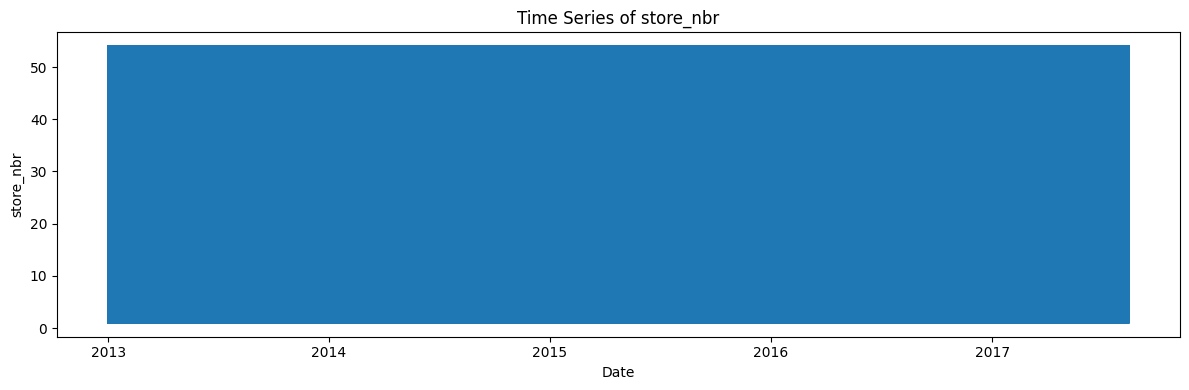

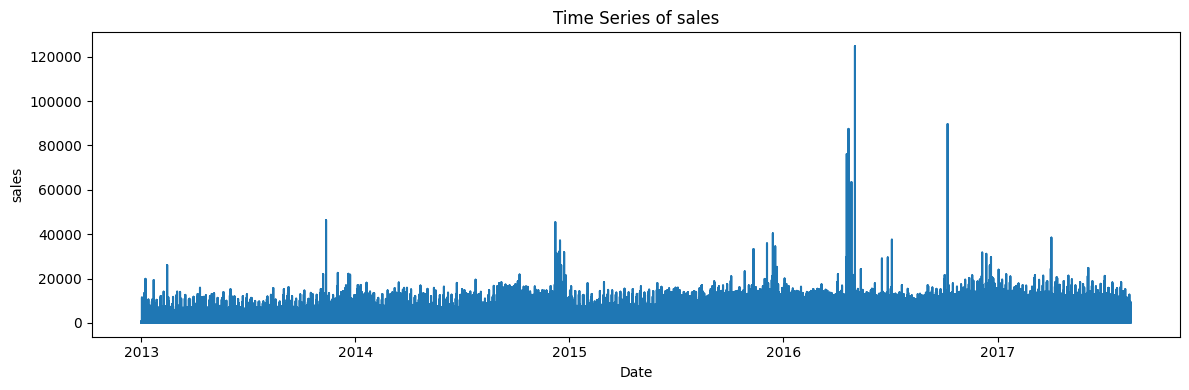

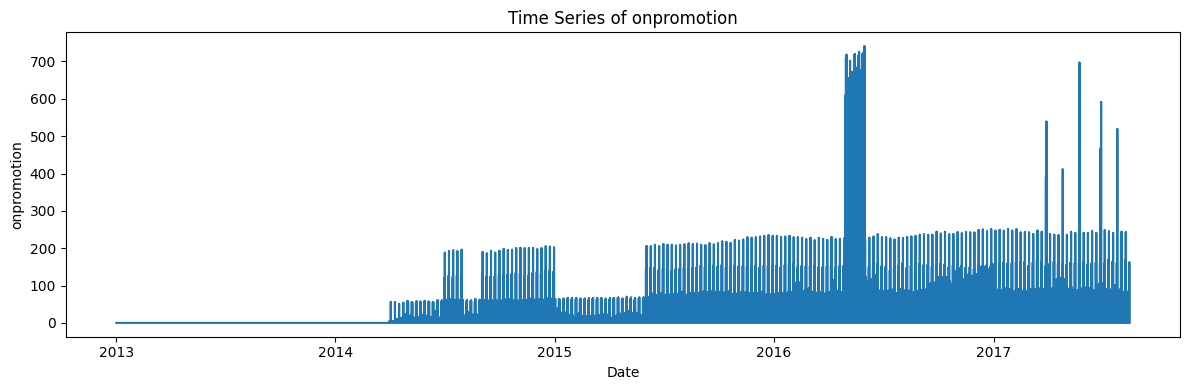

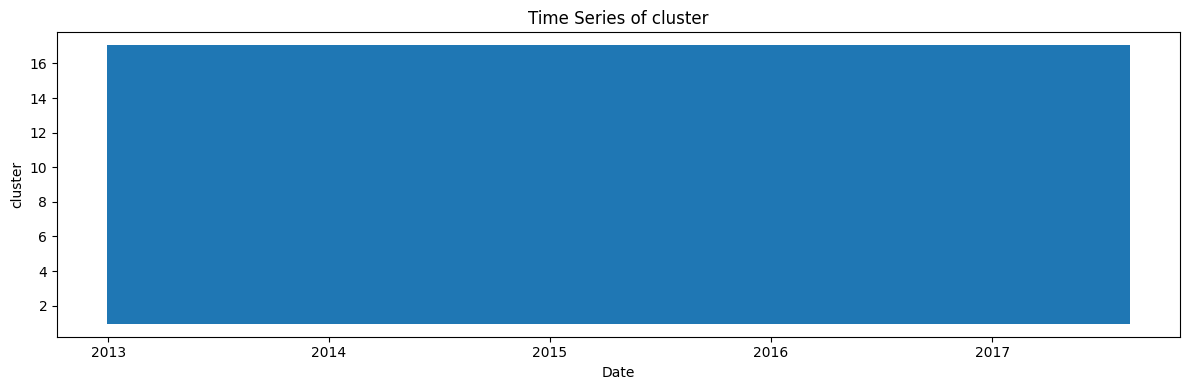

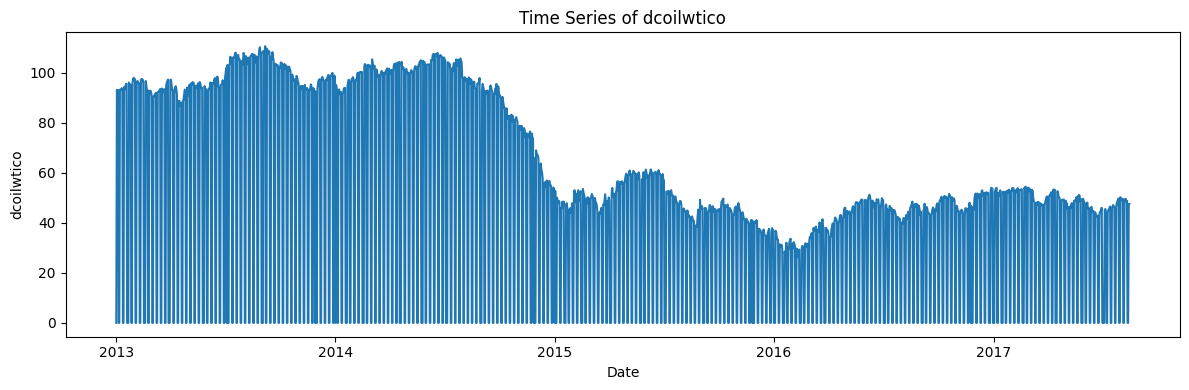

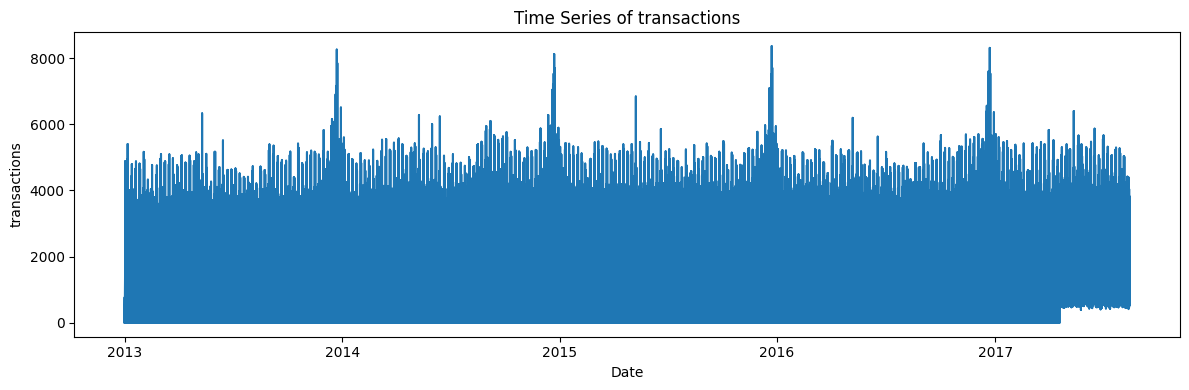

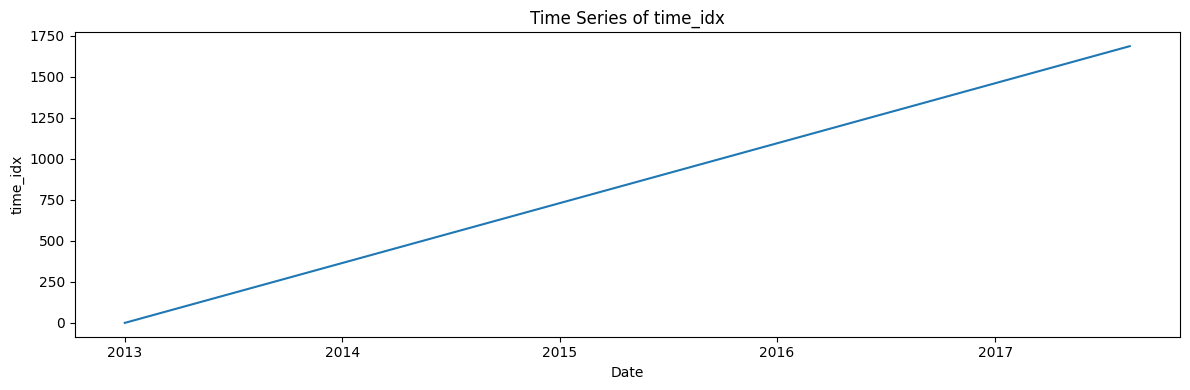

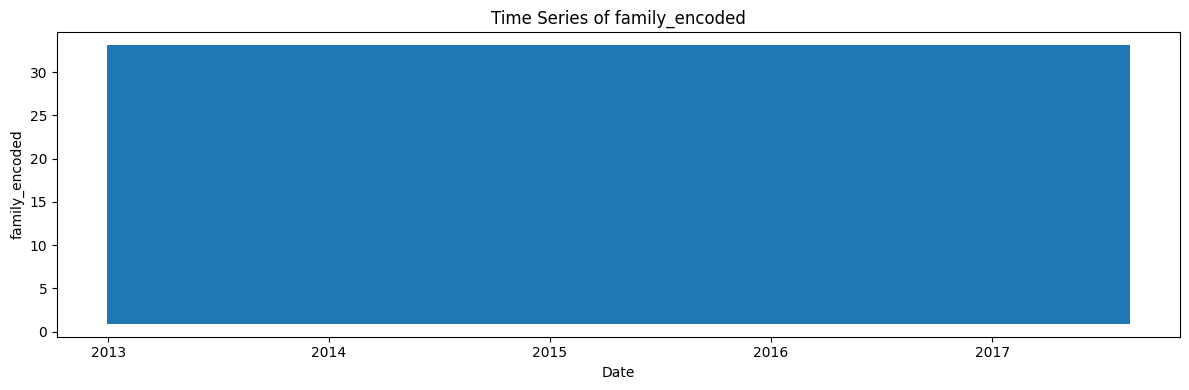

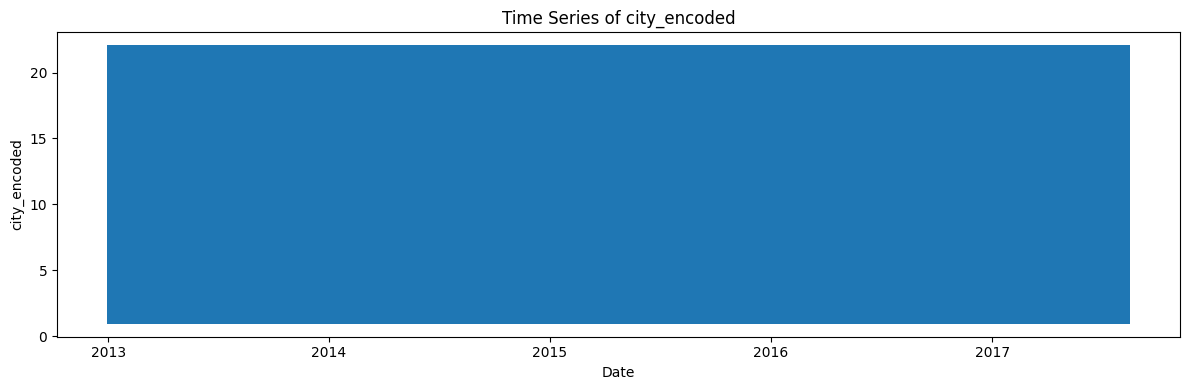

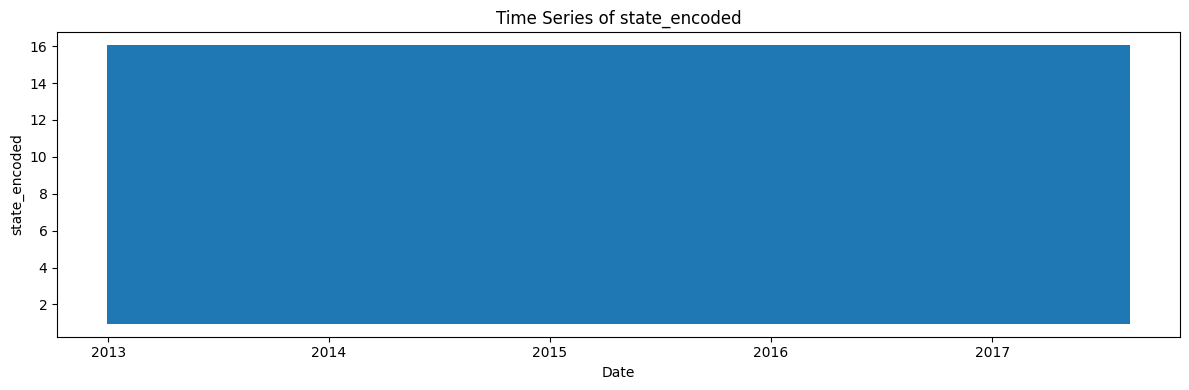

Only plotting first 10 columns.


In [37]:
plot_all_time_series(merged_df_final, num_cols_for_vis)

In [38]:
merged_df_final.head()

store_nbr  sales  onpromotion  cluster  dcoilwtico  transactions  \
date                                                                           
2013-01-01          1    0.0            0       13         0.0           0.0   
2013-01-01          1    0.0            0       13         0.0           0.0   
2013-01-01          1    0.0            0       13         0.0           0.0   
2013-01-01          1    0.0            0       13         0.0           0.0   
2013-01-01          1    0.0            0       13         0.0           0.0   

            time_idx  family_encoded  city_encoded  state_encoded  \
date                                                                
2013-01-01         0               1            19             13   
2013-01-01         0               2            19             13   
2013-01-01         0               3            19             13   
2013-01-01         0               4            19             13   
2013-01-01         0               5            19             13   

            type_x_encoded  type_y_encoded  locale_encoded  \
date                                                         
2013-01-01               4               5               3   
2013-01-01               4               5               3   
2013-01-01               4               5               3   
2013-01-01               4               5               3   
2013-01-01               4               5               3   

            locale_name_encoded  description_encoded  transferred_encoded  
date                                                                       
2013-01-01                    6                   52                    2  
2013-01-01                    6                   52                    2  
2013-01-01                    6                   52                    2  
2013-01-01                    6                   52                    2  
2013-01-01                    6                   52                    2

In [39]:
merged_df_final.columns

Index(['store_nbr', 'sales', 'onpromotion', 'cluster', 'dcoilwtico',
       'transactions', 'time_idx', 'family_encoded', 'city_encoded',
       'state_encoded', 'type_x_encoded', 'type_y_encoded', 'locale_encoded',
       'locale_name_encoded', 'description_encoded', 'transferred_encoded'],
      dtype='object')

### Data Preprocessing


In [40]:
merged_df_final.reset_index(inplace=True)
min_date = merged_df_final['date'].min()
merged_df_final['time_idx'] = (merged_df_final['date'] - min_date).dt.days
merged_df_final['store_nbr'] = merged_df_final['store_nbr'].astype(str)
merged_df_final['type_x_encoded'] = merged_df_final['type_x_encoded'].astype(str)
merged_df_final['cluster'] = merged_df_final['cluster'].astype(str)


In [41]:
max_encoder_length = 60
max_prediction_length = 20

training_cutoff = merged_df_final["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

In [42]:
training = TimeSeriesDataSet(
    
    merged_df_final,
    time_idx="time_idx",
    target="onpromotion",
    group_ids=["store_nbr"],
    min_encoder_length=14,  # keep encoder length short for speed
    max_encoder_length=14,
    min_prediction_length=20,
    max_prediction_length=20,
    static_categoricals=["store_nbr", "type_x_encoded", "cluster"],
    static_reals=["dcoilwtico"],
    time_varying_known_categoricals=["type_x_encoded"],
    time_varying_known_reals=["transactions"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["sales"],
    allow_missing_timesteps=True
)

In [43]:
validation = TimeSeriesDataSet.from_dataset(training, merged_df_final, min_prediction_idx=training_cutoff + 1)
batch_size = 32  # Even smaller batch size

# Create dataloaders with explicit handling of the last batch
train_dataloader = training.to_dataloader(
    train=True, 
    batch_size=batch_size, 
    num_workers=7,
    shuffle=True,
    drop_last=True  # Explicitly drop the last batch
)

val_dataloader = validation.to_dataloader(
    train=False, 
    batch_size=1, 
    num_workers=7,
    shuffle=False,
    drop_last=False  # Explicitly drop the last batch
)

# Try prediction with CPU
baseline_predictions = Baseline().predict(
    val_dataloader, 
    trainer_kwargs=dict(accelerator="gpu"),
    return_y=True
)

# Calculate SMAPE
targets = baseline_predictions.y[0].reshape(1782, 20)
smape = SMAPE()(baseline_predictions.output, targets)
print(f"SMAPE: {smape}")

/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecu

SMAPE: 0.605555534362793


### Modeling


In [44]:
pl.seed_everything(42)


trainer = pl.Trainer(accelerator="gpu", gradient_clip_val=1e-1)
net = pf.TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
)

Seed set to 42
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [01:05<00:00,  1.53it/s]
Learning rate set to 0.00031622776601683794
Restoring states from the checkpoint path at /home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.lr_find_0c717673-809f-46d3-861d-3ac3807cb0cc.ckpt
Restored all states from the checkpoint at /home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.lr_find_0c717673-809f-46d3-861d-3ac3807cb0cc.ckpt


suggested learning rate: 0.00031622776601683794


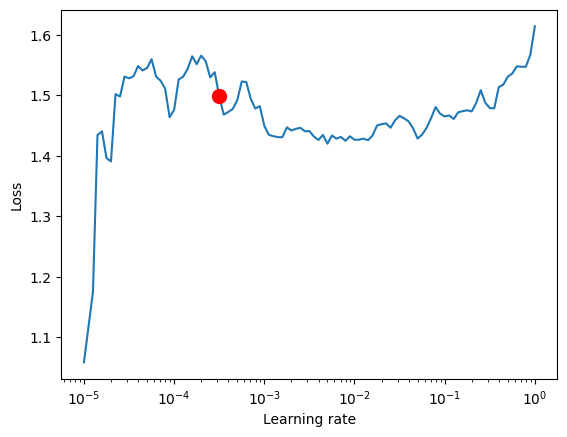

/tmp/ipykernel_28757/213940286.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [45]:
from lightning.pytorch.tuner import Tuner


res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [48]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = pf.TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.00031622776601683794, # Suggested optimal learning rate from prior tuning.
    hidden_size=64,                      # Size of the hidden layers.
    attention_head_size=4,               # Number of attention heads.
    dropout=0.1,                         # Dropout rate for regularization.
)


trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          

Epoch 29: 100%|██████████| 50/50 [03:14<00:00,  0.26it/s, v_num=26, train_loss_step=1.480, val_loss=0.967, train_loss_epoch=1.170]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 50/50 [03:14<00:00,  0.26it/s, v_num=26, train_loss_step=1.480, val_loss=0.967, train_loss_epoch=1.170]


In [49]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = pf.TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [55]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [64]:
type(predictions)
print(predictions.output.shape)
print(predictions.y[0].shape)

torch.Size([1782, 20])
torch.Size([1, 35640])


In [ ]:

# targets = predictions.y[0].reshape(1782, 20)
# print("Shape of predictions.output:", predictions.output.shape)
# # print("Shape of predictions.y:", predictions.y.shape)

# MAE()(predictions.output, targets)

Shape of predictions.output: torch.Size([1782, 20])


tensor(1.4896, device='cuda:0')

In [67]:
best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu"), return_y=True)
targets = predictions.y[0].reshape(1782, 20)
MAE()(predictions.output, targets)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(1.4896, device='cuda:0')

In [91]:
predictions = net.predict(
    val_dataloader,
    mode="raw", # or "quantiles" if you want specific quantiles
    return_x=True,
    trainer_kwargs=dict(accelerator="gpu")
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/metaphysicist/Coding/2025/Projects/Time_Series/Sales_Ecuador/.venv/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:121: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([1, 20, 4, 1070]). Returning list instead of torch.Tensor.
  warnings.warn(


In [83]:
predictions.output.shape

torch.Size([1782, 20])

In [84]:
series = validation.x_to_index(predictions.x)["time_idx"]

In [92]:
print(type(predictions.x))
print(type(predictions.output))

<class 'dict'>
<class 'pytorch_forecasting.utils._utils.TupleOutputMixIn.to_network_output.<locals>.Output'>


In [93]:
predictions.x
predictions.output

Output(prediction=tensor([[[-6.4071e-02, -1.5557e-02, -5.8686e-03,  ...,  6.4460e-03,
           1.1153e-01,  1.0267e+00],
         [-3.3904e-02, -5.2611e-03, -5.4505e-03,  ...,  1.0166e-02,
           7.9744e-01,  6.5798e+00],
         [-2.0464e-02, -3.1702e-03, -4.2097e-03,  ...,  2.7262e-02,
           1.7045e+00,  1.0489e+01],
         ...,
         [-1.7365e-02, -1.9121e-03, -8.0660e-03,  ...,  7.4984e-01,
           4.6748e+00,  1.5575e+01],
         [-1.7313e-02, -1.8848e-03, -8.0456e-03,  ...,  7.5253e-01,
           4.6787e+00,  1.5577e+01],
         [-1.7412e-02, -1.8330e-03, -7.9853e-03,  ...,  7.5440e-01,
           4.6815e+00,  1.5575e+01]],

        [[-6.4068e-02, -1.5556e-02, -5.8669e-03,  ...,  6.4490e-03,
           1.1151e-01,  1.0261e+00],
         [-3.3901e-02, -5.2687e-03, -5.4543e-03,  ...,  1.0149e-02,
           7.9602e-01,  6.5724e+00],
         [-2.0481e-02, -3.1697e-03, -4.2082e-03,  ...,  2.7180e-02,
           1.7026e+00,  1.0482e+01],
         ...,
       

In [ ]:
series = validation.x_to_index(predictions.x)["store_nbr"]

In [ ]:
from matplotlib import axes


zoom_start_x = -50 # Start 50 steps before time_idx 0

for idx in range(4):
    plt.figure()
    fig, ax = plt.subplots(1, 1)
    
    best_model.plot_prediction(predictions.x, predictions.output, idx=idx, add_loss_to_title=True, plot_attention=False)
    plt.suptitle(f"Series: {series.iloc[idx]}")

    ax.set_xlim(zoom_start_x, zoom_end_x)
    plt.show()

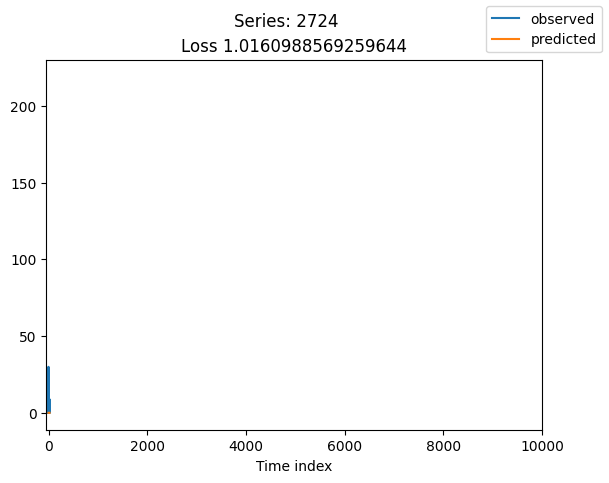

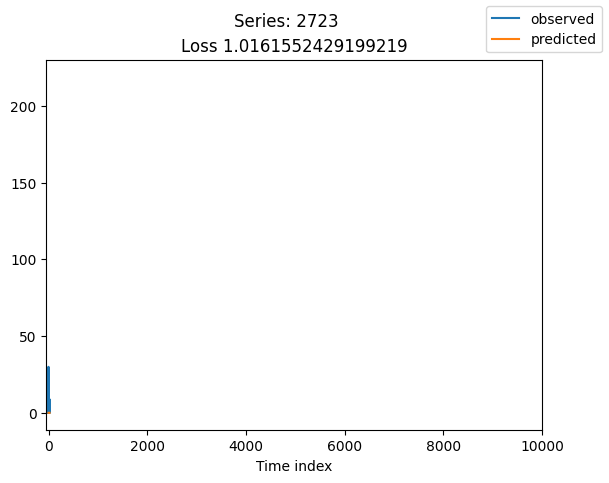

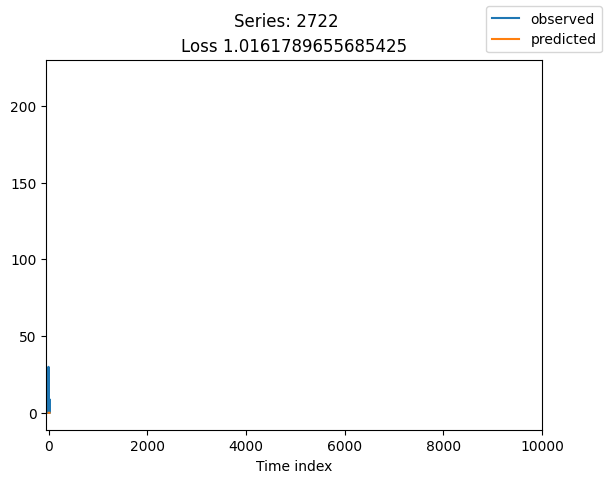

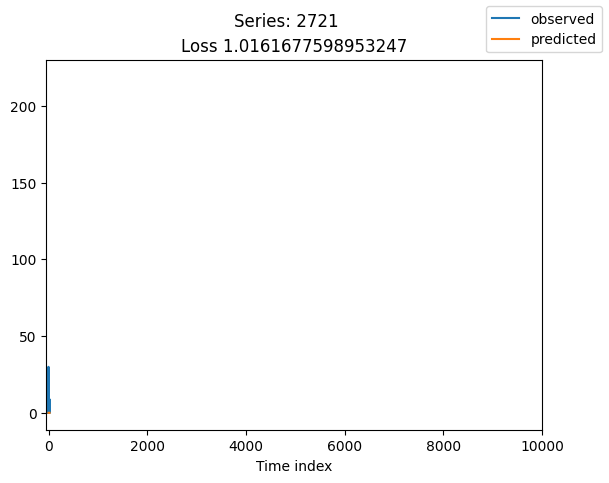

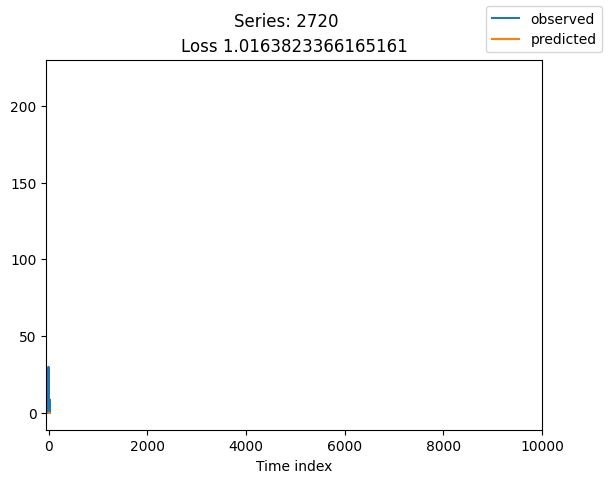

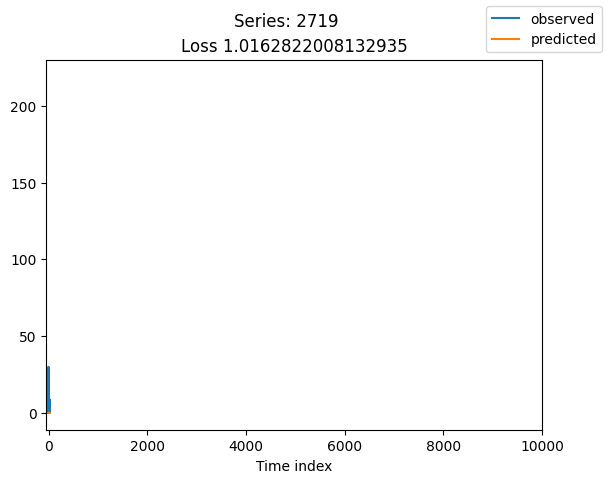

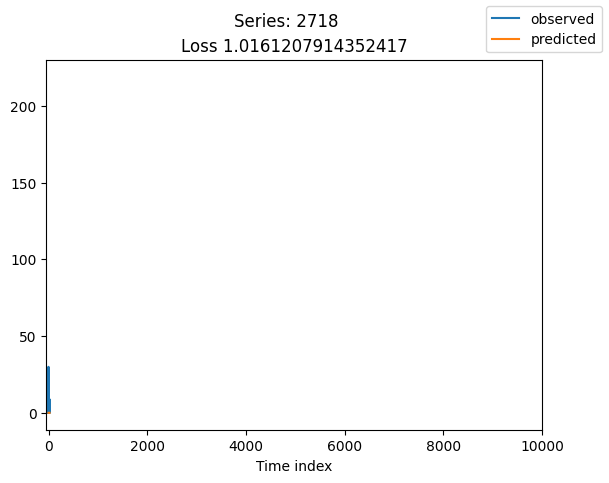

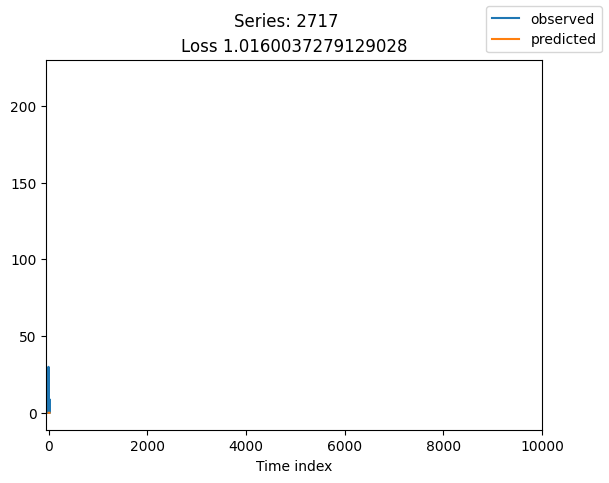

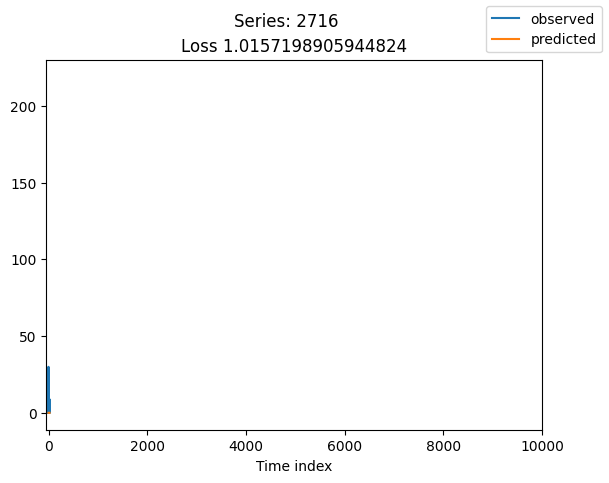

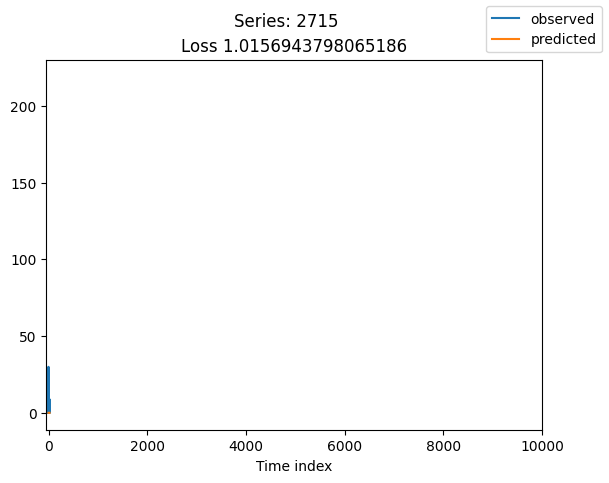

In [ ]:
for idx in range(n_examples):
    # plot_prediction internally creates a figure and axes.
    # It returns a Figure object (or a list of them if multiple plots were generated,
    # but for a single idx, it's usually one Figure).
    fig = best_model.plot_prediction(
        predictions.x,
        predictions.output,
        idx=idx,
        add_loss_to_title=True,
        plot_attention=False # Keep this False to avoid the previous error
    )

    # plot_prediction might return a list of figures if it internally creates multiple plots for one call.
    # To be safe, let's assume it returns a list and take the first figure if it's a list, otherwise use it directly.
    if isinstance(fig, list):
        current_fig = fig[0] # Take the first figure if it's a list
    else:
        current_fig = fig # Otherwise, it's already the figure

    # Set the super title for the current figure
    current_fig.suptitle(f"Series: {series.iloc[idx]}")

    # To zoom, we need to access the Axes object(s) within the Figure.
    # plot_prediction usually puts the main time series plot in the first Axes.
    if current_fig.axes: # Check if there are any axes in the figure
        main_ax = current_fig.axes[0] # Get the first Axes object

        # --- Zooming in on the x-axis ---
        main_ax.set_xlim(zoom_start_x, zoom_end_x)

        # Optional: Adjust y-axis limits for better visibility of the zoomed region
        # This part requires some careful thought to avoid clipping valid data.
        # It might be best to let matplotlib auto-scale the y-axis,
        # or calculate min/max of the relevant data points in the zoomed x-range.
        # For simplicity, I'll omit dynamic Y-axis zooming here, as it can be complex.
        # If you need it, you'd calculate min/max of y values within your x-range.

    plt.show() # Display the figure
    plt.close(current_fig) # Close the figure to free up memory (important in loops)

### Training


### Testing
